In [1]:
from torch import optim
import os
import torchvision.utils as vutils
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Argument

In [2]:
BATCH_SIZE = 256
Z_DIM = 100
LABEL_EMBED_SIZE = 10
NUM_CLASSES = 10
IMGS_TO_DISPLAY_PER_CLASS = 10
CHANNELS = 3
EPOCHS = 200
LOAD_MODEL = False

# path
model_name = 'CGAN'
image_path = os.path.join(model_name, 'images')
model_path = os.path.join(model_name, 'models')
samples_path = os.path.join(model_name, 'samples')

In [3]:
# Fix seed for reproducibility
torch.manual_seed(12)
torch.backends.cudnn.deterministic = True

torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    "device",
    torch.cuda.current_device(),
    torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 4090


## Load data

In [4]:
# Data loader
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataloader = DataLoader(
    dataset=datasets.CIFAR10(
        root="data/cifar10", train=True, download=True, transform=transform
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Files already downloaded and verified


## Some Methods

In [5]:
# Method for storing generated images
def generate_imgs(z, fixed_label, epoch=0, last=False):
    gen.eval()
    fake_imgs = gen(z, fixed_label)
    fake_imgs = (fake_imgs + 1) / 2
    fake_imgs_ = vutils.make_grid(fake_imgs, normalize=False, nrow=IMGS_TO_DISPLAY_PER_CLASS)
    if last:
        vutils.save_image(fake_imgs_, os.path.join(model_name, 'final.png'))
    else:
        vutils.save_image(fake_imgs_, os.path.join(samples_path, 'sample_' + str(epoch) + '.png'))

# Method for logging training losses
def plot_training_loss(losses, save_path=None, display=False):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path)
    if display:
        plt.show()
    plt.close()

## GAN model

In [6]:
# Networks
def conv_block(c_in, c_out, k_size=4, stride=2, pad=1, use_bn=True, transpose=False):
    module = []
    if transpose:
        module.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    else:
        module.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    if use_bn:
        module.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*module)


class Generator(nn.Module):
    def __init__(self, z_dim=10, num_classes=10, label_embed_size=5, channels=3, conv_dim=64):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, label_embed_size)
        self.tconv1 = conv_block(z_dim + label_embed_size, conv_dim * 4, pad=0, transpose=True)
        self.tconv2 = conv_block(conv_dim * 4, conv_dim * 2, transpose=True)
        self.tconv3 = conv_block(conv_dim * 2, conv_dim, transpose=True)
        self.tconv4 = conv_block(conv_dim, channels, transpose=True, use_bn=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, 0.0, 0.02)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, label):
        x = x.reshape([x.shape[0], -1, 1, 1])
        label_embed = self.label_embedding(label)
        label_embed = label_embed.reshape([label_embed.shape[0], -1, 1, 1])
        x = torch.cat((x, label_embed), dim=1)
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        x = F.relu(self.tconv3(x))
        x = torch.tanh(self.tconv4(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, num_classes=10, channels=3, conv_dim=64):
        super(Discriminator, self).__init__()
        self.image_size = 32
        self.label_embedding = nn.Embedding(num_classes, self.image_size*self.image_size)
        self.conv1 = conv_block(channels + 1, conv_dim, use_bn=False)
        self.conv2 = conv_block(conv_dim, conv_dim * 2)
        self.conv3 = conv_block(conv_dim * 2, conv_dim * 4)
        self.conv4 = conv_block(conv_dim * 4, 1, k_size=4, stride=1, pad=0, use_bn=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.0, 0.02)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, label):
        alpha = 0.2
        label_embed = self.label_embedding(label)
        label_embed = label_embed.reshape([label_embed.shape[0], 1, self.image_size, self.image_size])
        x = torch.cat((x, label_embed), dim=1)
        x = F.leaky_relu(self.conv1(x), alpha)
        x = F.leaky_relu(self.conv2(x), alpha)
        x = F.leaky_relu(self.conv3(x), alpha)
        x = torch.sigmoid(self.conv4(x))
        return x.squeeze()

In [7]:
gen = Generator(z_dim=Z_DIM, num_classes=NUM_CLASSES, label_embed_size=LABEL_EMBED_SIZE, channels=CHANNELS)
dis = Discriminator(num_classes=NUM_CLASSES, channels=CHANNELS)

# Load previous model   
if LOAD_MODEL:
    gen.load_state_dict(torch.load(os.path.join(model_path, 'Generator weights.pth')))
    dis.load_state_dict(torch.load(os.path.join(model_path, 'Discriminator weights.pth')))

# Define Optimizers
g_opt = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)
d_opt = optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)

# Loss functions
loss_fn = nn.BCELoss()

# Fix images for viz
fixed_z = torch.randn(IMGS_TO_DISPLAY_PER_CLASS*NUM_CLASSES, Z_DIM)
fixed_label = torch.arange(0, NUM_CLASSES)
fixed_label = torch.repeat_interleave(fixed_label, IMGS_TO_DISPLAY_PER_CLASS)

# GPU Compatibility
gen, dis = gen.to(device), dis.to(device)
fixed_z, fixed_label = fixed_z.to(device), fixed_label.to(device)

total_iters = 0
max_iter = len(dataloader)

In [8]:
# record trianing loss
record = {"D_loss": [], "G_loss": []}

# Training
for epoch in range(EPOCHS):
    gen.train()
    dis.train()

    for i, data in enumerate(dataloader):

        total_iters += 1

        # Loading data
        x_real, x_label = data
        x_real = x_real.to(device)
        x_label = x_label.to(device)

        z_fake = torch.randn(x_label.size(0), Z_DIM).to(device)

        real_label = torch.ones(x_label.size(0)).to(device)
        fake_label = torch.zeros(x_label.size(0)).to(device)

        # Generate fake data
        x_fake = gen(z_fake, x_label)

        # Train Discriminator
        fake_out = dis(x_fake.detach(), x_label)
        real_out = dis(x_real.detach(), x_label)
        d_loss = (loss_fn(fake_out, fake_label) + loss_fn(real_out, real_label)) / 2

        d_opt.zero_grad()
        d_loss.backward()
        d_opt.step()

        # Train Generator
        fake_out = dis(x_fake, x_label)
        g_loss = loss_fn(fake_out, real_label)

        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

        if i % 100 == 0:
            print("Epoch: " + str(epoch + 1) + "/" + str(EPOCHS)
                  + "|Batch: " + str(i) + "/" + str(max_iter)
                  + "\td_loss:" + str(round(d_loss.item(), 4))
                  + "\tg_loss:" + str(round(g_loss.item(), 4))
                  )
    record["D_loss"].append(round(d_loss.item(), 4) / len(dataloader))
    record["G_loss"].append(round(g_loss.item(), 4) / len(dataloader))

    plot_training_loss(record["D_loss"], save_path=os.path.join(image_path, 'DLoss.png'))
    plot_training_loss(record["G_loss"], save_path=os.path.join(image_path, 'GLoss.png'))

    if (epoch + 1) % 5 == 0:
        torch.save(gen.state_dict(), os.path.join(model_path, 'Generator weights.pth'))
        torch.save(dis.state_dict(), os.path.join(model_path, 'Discriminator weights.pth'))

        generate_imgs(fixed_z, fixed_label, epoch=epoch + 1)
        generate_imgs(fixed_z, fixed_label, last=True)

Epoch: 1/200|Batch: 0/196	d_loss:0.7362	g_loss:1.8373
Epoch: 1/200|Batch: 100/196	d_loss:0.1327	g_loss:4.5403
Epoch: 2/200|Batch: 0/196	d_loss:0.3355	g_loss:2.9198
Epoch: 2/200|Batch: 100/196	d_loss:0.5313	g_loss:1.8149
Epoch: 3/200|Batch: 0/196	d_loss:0.3266	g_loss:3.4882
Epoch: 3/200|Batch: 100/196	d_loss:0.2518	g_loss:3.0514
Epoch: 4/200|Batch: 0/196	d_loss:0.3186	g_loss:3.9683
Epoch: 4/200|Batch: 100/196	d_loss:0.2377	g_loss:3.6976
Epoch: 5/200|Batch: 0/196	d_loss:0.4283	g_loss:1.9387
Epoch: 5/200|Batch: 100/196	d_loss:0.2848	g_loss:3.4204
Epoch: 6/200|Batch: 0/196	d_loss:0.4818	g_loss:3.8976
Epoch: 6/200|Batch: 100/196	d_loss:0.4089	g_loss:1.9486
Epoch: 7/200|Batch: 0/196	d_loss:0.3103	g_loss:3.6003
Epoch: 7/200|Batch: 100/196	d_loss:0.3429	g_loss:2.9461
Epoch: 8/200|Batch: 0/196	d_loss:0.3421	g_loss:2.5465
Epoch: 8/200|Batch: 100/196	d_loss:0.2758	g_loss:2.6339
Epoch: 9/200|Batch: 0/196	d_loss:0.3433	g_loss:1.5116
Epoch: 9/200|Batch: 100/196	d_loss:0.2803	g_loss:2.5327
Epoch: 10/

In [9]:
# Final images
generate_imgs(fixed_z, fixed_label, last=True)

# show final result

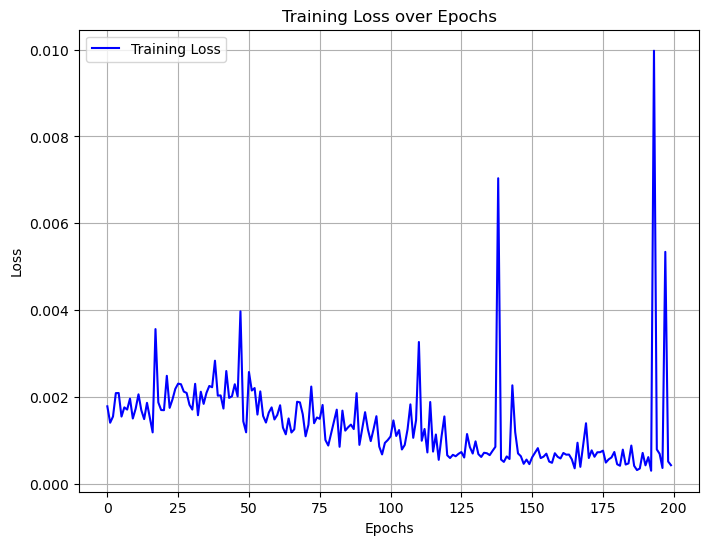

In [10]:
# Plot Descriminator training loss
plot_training_loss(record["D_loss"], display=True)

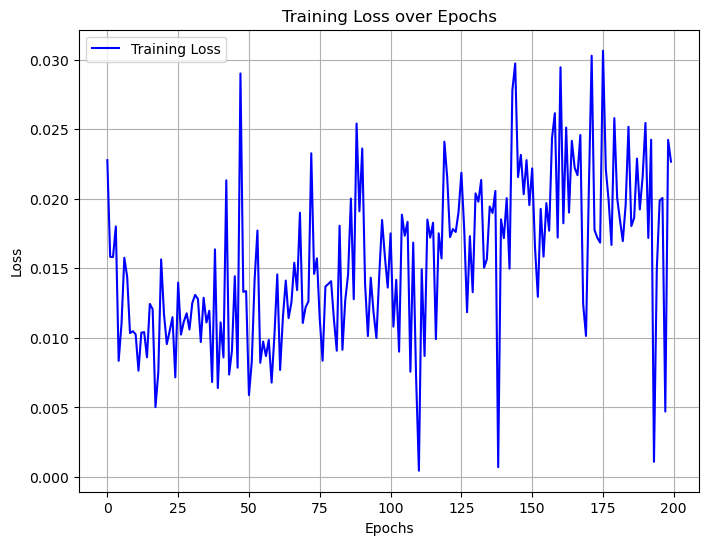

In [11]:
# Plot Generator training loss
plot_training_loss(record["G_loss"], display=True)

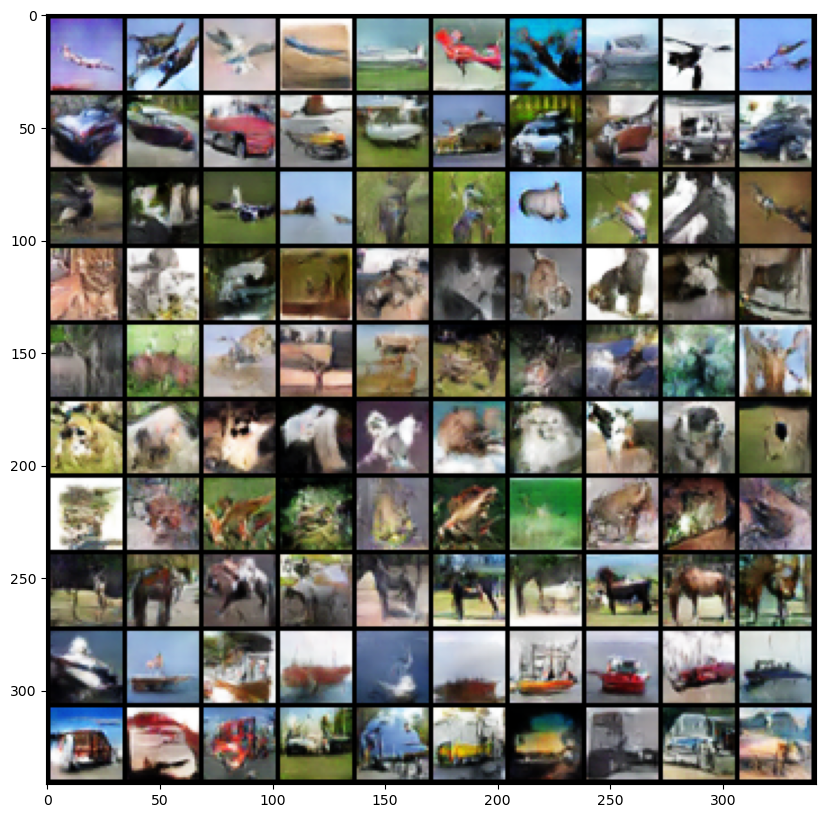

In [12]:
from PIL import Image
img_path = os.path.join(model_name, 'final.png')
final_image = Image.open(img_path)
plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.show()